*Данг Куинь Ньы, Коган Александра, декабрь 2020*

Реализуем EM-алгоритм для примера смеси 2 нормальных распределений

In [ ]:
#Импортим нужные библиотеки
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
np.random.seed(123)

Сгенерим 2 выборки из нормальных распределений. Первое из $\mathcal{N}(0,1)$ второе - из $\mathcal{N}(4,0.25)$ И построим их гистограмму

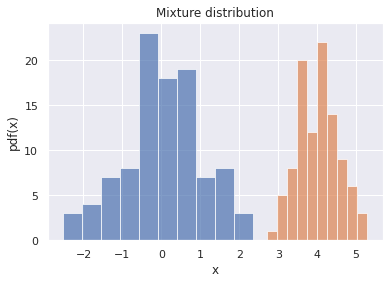

In [ ]:
y1 = np.random.normal(0, 1, 100)
y2 = np.random.normal(4, 0.5, 100)
plt.hist(y1, alpha = 0.7)
plt.hist(y2, alpha = 0.7)
plt.title('Mixture distribution')
plt.xlabel('x')
plt.ylabel('pdf(x)')
plt.show()

Но сначала сделаем EM-алгоритм на игрушечных данных.

In [ ]:
x = np.array([5, 6, 2, 1, 1, 3, 7, 10])

Для начала EM-алгоритма нужен начальный вектор параметров $\theta_{old}$

$\theta_{old}$ - массив: $[\mu_1, \sigma_1^2, \mu_2, \sigma_2^2, p_1]$ Заметим, что так как кластеров только 2, то нет необходимости хранить $p_2$. То есть достаточно хранить $p_1, ... p_{k-1}$, где $k$- количество кластеров.

Начальные значения могут быть практически любыми, их можно брать случайными. Однако лучше всего брать какие-нибудь разумные значения (если, допустим, вся выборка содержится в интервале (0,1), то брать $\mu_1 = 100000$ крайне странно) Можно воспользоваться эвристикой, предложенной на лекции:

$\mu_1 = min(X)$

$\mu_2 = max(X)$

$\sigma_1^2 = \sigma_2^2 = \frac{max(X) - min(X)}{2}$

$p_1 = \frac{1}{2}$

Логика за этой эвристикой: один кластер справа, другой слева, поэтому и возьмем число справа и слева, а дисперсия - усредненный разброс.

In [ ]:
theta = np.array([np.min(x), (np.max(x) - np.min(x)) / 2, np.max(x), (np.max(x) - np.min(x)) / 2, 1/2])
theta

array([ 1. ,  4.5, 10. ,  4.5,  0.5])

Далее зададим функцию плотности x. Отметим, что данную функцию для нормального распределения не обязательно задавать вручную, можно воспользоваться `scipy.stats.norm.pdf`

In [ ]:
def f(x, mu, sigma2):
    return 1 / np.sqrt(2 * np.pi * sigma2) * np.exp(-1/2 * 1/sigma2 * (x - mu)**2)

Реализуем один шаг для EM-алгоритма, подробно его разбирая.

Для начала рассчитаем $P(z_i = 1 | x_i, \theta_{old})$ (т.е. найдем распределение латентных переменных)

У нас $\theta_{old}$ лежит в массиве theta

In [ ]:
p_z_1 = f(x, mu = theta[0], sigma2 = theta[1]) * theta[4] / (theta[4] * f(x, mu = theta[0], sigma2 = theta[1]) + 
                                                       (1-theta[4]) * f(x, mu = theta[2], sigma2 = theta[3]))
p_z_1

array([7.31058579e-01, 2.68941421e-01, 9.99088949e-01, 9.99876605e-01,
       9.99876605e-01, 9.93307149e-01, 4.74258732e-02, 1.23394576e-04])

Тепреь в массиве p_z_1 лежат $P(z_i = 1 | x_i, \theta_{old})$. Отметим, что отдельно высчитывать $P(z_i = 2 | x_i, \theta_{old})$ не надо, т. к. $P(z_i = 2 | x_i, \theta_{old}) = 1- P(z_i = 1 | x_i, \theta_{old})$.

Следовательно, если есть k кластеров, то надо посчитать $P(z_i = j | x_i, \theta_{old})$ для $j \in \{ 1,..., k-1\}$

Теперь можно реализовать M-шаг: найдем новые значения $\theta$, пользуясь формулами из конспекта

In [ ]:
mu_1 = np.sum(p_z_1 * x) / np.sum(p_z_1)
mu_2 = np.sum((1-p_z_1) * x) / np.sum(1-p_z_1)

sigma2_1 = np.sum((x - mu_1) ** 2 * p_z_1)/ np.sum(p_z_1)
sigma2_2 = np.sum((x - mu_2) ** 2 * (1 - p_z_1))/ np.sum(1 - p_z_1)

p1 = np.sum(p_z_1) / len(x)

Теперь просто сложим полученные параметры в правильном порядке в один масив theta_new

In [ ]:
theta_new = np.array([mu_1, sigma2_1, mu_2, sigma2_2, p1])
theta_new

array([2.49618283, 2.74390095, 7.57355004, 3.36811658, 0.62996232])

Один шаг EM-алгоритма готов!

Теперь хотим собрать EM-алгоритм, но для этого надо определиться, сколько шагов делать/задать критерии остановки.

Для нашего EM-алгоритма зададим максимально количество шагов = 100, критерий остановки- если $(Q_t - Q_{t-1}) < 10^{-4}$, где $Q_t$ - это $Q$ на шаге $t$ 

Отметим, что в числах 100 и $10^{-4}$ ничего магического нет, их можно поменять. 

Для обработки критерия нам нужна функция $Q$ и логарифм плотности.

Также скажем, что для подсчета  логарифма плотности нормального можно воспользоваться scipy.stats.norm.logpdf, а не писать свою функцию lnf.

In [ ]:
def lnf(x, mu, sigma2):
    return -1/2 * np.log(2 * np.pi * sigma2) - 1/2 * (x - mu) ** 2 / sigma2

Для подсчета $Q$ нам нужны X, theta и p_z_1. Отметим, что в конспекте пишется $Q(theta, \theta_{old})$, но $\theta_{old}$ подавать необязательно, так как для рассчета $Q$ используется p_z_1, которые рассчитывались на основе $\theta_{old}$ и содержат всю нужную информацию.

In [ ]:
def Q_f(x, theta, p_z_1):
    ell1 = lnf(x, theta[0], theta[1]) + np.log(theta[4])
    ell2 = lnf(x, theta[2], theta[3]) + np.log(1 - theta[4])
    return np.sum(p_z_1 * ell1 + (1 - p_z_1) * ell2)

Теперь уже можно реализовать функцию EM-алгоритма для нахождения параметров при разделении смеси 2 нормальных распределений.

Кроме параметров также будем возвращать Q_history - массив, где будут записаны $Q_t$ на каждой итерации алгоритма

Начальные аргументы функции - это сама смесь x и theta - начальные параметры

In [ ]:
def EM(x, theta):
    
    Q_history = []
    
    for i in range(100):
        
        #E-шаг
        p_z_1 = f(x, mu = theta[0], sigma2 = theta[1]) * theta[4] / (theta[4] * f(x, mu = theta[0], sigma2 = theta[1]) + 
                                                       (1-theta[4]) * f(x, mu = theta[2], sigma2 = theta[3]))
        #Расчет Q_t
        Q_history.append(Q_f(x, theta, p_z_1))
        
        #Проверка критерия остановки
        if i > 0:
            if (Q_history[i] - Q_history[i-1])**2 < 1e-4:
                break
        
        #M-шаг

        #по формулам находим новые параметры
        mu_1 = np.sum(p_z_1 * x) / np.sum(p_z_1)
        mu_2 = np.sum((1-p_z_1) * x) / np.sum(1-p_z_1)
        sigma2_1 = np.sum((x - mu_1) ** 2 * p_z_1)/ np.sum(p_z_1)
        sigma2_2 = np.sum((x - mu_2) ** 2 * (1-p_z_1))/ np.sum(1 - p_z_1)
        p1 = np.sum(p_z_1) / len(x)

        #Записываем их в массив в нужном порядке
        theta_new = np.array([mu_1, sigma2_1, mu_2, sigma2_2, p1])
        
        #Обновляем параметры
        theta = theta_new
    
    return (theta, Q_history)

Проверим теперь работу EM-алгоритма на наших игрушечных данных

In [ ]:
theta, Q_history = EM(x, theta)
theta

array([1.61403194, 0.58183979, 6.49747214, 5.07879106, 0.43462642])

Так как игрушечные данные на самом деле не были сгенерированы из нормальных распределений, то сложно оценить, насколько хорошо работает алгоритм.

Также построим график Q_history

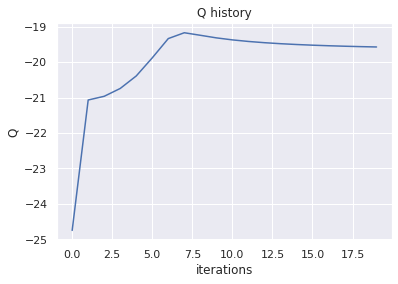

In [ ]:
plt.plot(Q_history)
plt.title('Q history')
plt.xlabel('iterations')
plt.ylabel('Q')
plt.show()

Заметим, что Q не монотонен. Q возрастает на первых 6-7 итерациях, а потом начинает убывать. (Подождите, мы же  максимизировали, почему Q убывает?? - Об объяснении такой динамики можно прочитать [здесь](https://stats.stackexchange.com/questions/341173/em-algorithm-seems-to-work-but-q-is-not-monotonic-possible-reasons))

Теперь протестируем EM-алгоритм на случайных данных. Вспомним о тех y1, y2, которые были сгенерированы в начале ноутбука: по 100 наблюдений из $\mathcal{N}(0,1)$ и $\mathcal{N}(4,0.25)$.

In [ ]:
x = np.hstack((y1, y2))
#Чтобы все было честно, перемешаем выборку
np.random.shuffle(x)
#Начальное приближение возьмем с использованием эвристики
theta = np.array([np.min(x), (np.max(x) - np.min(x)) / 2, np.max(x), (np.max(x) - np.min(x)) / 2, 1/2])
theta

array([-2.52790159,  3.90724998,  5.28659836,  3.90724998,  0.5       ])

Отментим, что изначально $\mu_i$ и $\sigma_i^2$ не совпадают  с настоящими.

применим EM-алгоритм.

In [ ]:
theta, Q = EM(x, theta)

In [ ]:
theta

array([0.05405588, 1.12112515, 4.03175408, 0.26234515, 0.5033544 ])

Посмотрим на результаты:

Наши настоящие параметры: 0, 1, 4, 0.25

Важно! Наш EM-алгоритм выдает оценки $\sigma^2$, поэтому сравниваем с 1 и 0.25

Все параметры были найдены хорошо,но не отлично. Ошибки во первом-втором-третьем знаке после запятой. Это может проиходить из-за того, что число $10^{-4}$ слишком большое и алгоритм слоишком рано заканчивается или начальное приближение плохое. Любопытные читатели могут сами поиграться с этими параметрами.




На последок построим  график Q.

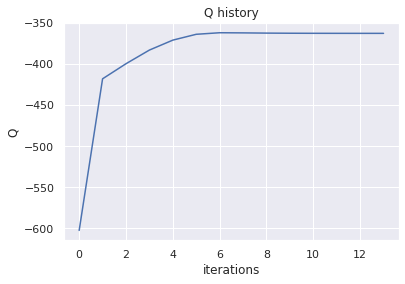

In [ ]:
plt.plot(Q)
plt.title('Q history')
plt.xlabel('iterations')
plt.ylabel('Q')
plt.show()

 Тут хотя бы он монотонен :)